In [10]:
%matplotlib inline
import glob                       # Unix-style pathname pattern; enables to list files using a wildcard *
import numpy as np
import xarray as xr               # Import xarray (python interface to manipulate multidimensional data)
import matplotlib.pyplot as plt   # Define the namespace for the plots
plt.rcParams["figure.figsize"] = (10,5) #define the size of the figures in the whole notebook
import cartopy                    # Import the mapping library (note: this is needed to deal with mapping projections)
import cartopy.crs as ccrs        #  Define the namespace for the geographical projections
# The following is not usually recommended, but avoid un-necessary warning messages in today's training frame
import warnings
import sys, os
from datetime import datetime, timedelta
import pandas as pd
warnings.filterwarnings('ignore')

In [11]:
# Function to mask area of full satellite ds
def mask_area(xr_ds, lon_min, lon_max, lat_min, lat_max):
    # Create boolean masks for longitude and latitude conditions
    lon_mask = (xr_ds.longitude >= lon_min) & (xr_ds.longitude <= lon_max)
    lat_mask = (xr_ds.latitude >= lat_min) & (xr_ds.latitude <= lat_max)

    # Apply masks to select data within the specified range
    xr_ds_sub_area = xr_ds.where(lon_mask & lat_mask, drop=True)

    return xr_ds_sub_area

In [12]:
# Output dir
ENV_ROOT = os.getcwd() # environment root directory
OUTPUT_ROOT = '../../../../data/sat/sentinel3a/'   # output root directory
if OUTPUT_ROOT not in sys.path:
    sys.path.append(OUTPUT_ROOT)
# FIG_ROOT = '../figures/'
os.chdir(ENV_ROOT)


In [13]:
# Only select the files between2 27-31 Jan 2022
start_date = datetime(2022, 1, 27)
end_date = datetime(2022, 1, 31)

# Generate a list of date strings within the range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
date_strings = date_range.strftime('%Y%m%d')

# Generate a pattern for matching files
pattern_base = '*global_vavh_l3_rt_s3a_'
l3_files = [file for date_str in date_strings for file in glob.glob(f'{OUTPUT_ROOT}{pattern_base}{date_str}*.nc')]
l3_files.sort()

In [14]:
# Open each file individually
datasets = [xr.open_dataset(file, engine='netcdf4') for file in l3_files]

# Concatenate the datasets along the time dimension
s3a_dataset = xr.concat(datasets, dim='time')

s3a_dataset

<xarray.Dataset>
Dimensions:          (time: 141416)
Coordinates:
  * time             (time) datetime64[ns] 2022-01-27T00:02:45 ... 2022-01-29...
    latitude         (time) float64 -38.53 -38.59 -38.65 ... 50.51 50.45 50.39
    longitude        (time) float64 142.5 142.5 142.4 ... 160.6 160.6 160.6
Data variables:
    VAVH             (time) float32 0.94 0.961 1.022 1.067 ... 3.205 3.208 3.204
    VAVH_UNFILTERED  (time) float32 0.608 0.863 1.251 0.899 ... 3.226 3.432 3.23
    WIND_SPEED       (time) float32 nan nan 0.706 1.031 ... 10.49 11.18 12.37
Attributes: (12/28)
    Conventions:               CF-1.6
    first_meas_time:           2022-01-27 00:02:45
    last_meas_time:            2022-01-27 02:34:08
    comment:                   Significant Wave Height and Wind Speed measure...
    creator_email:             servicedesk.cmems@mercator-ocean.eu
    references:                http://marine.copernicus.eu
    ...                        ...
    equator_time:              2022-01-26T23:51:50.177000
    equator_longitude:         152.12
    creation_date:             2022-06-27T13:26:33
    software_version:          L3RT_SWH: (conf 3.1.0-SNAPSHOT) (docker None);...
    history:                   2022-06-27T13:26:33:Creation
    product_version:           6_0

In [15]:
# Define longitude and latitude ranges
lon_min = -4
lon_max = 10
lat_min = 51
lat_max = 61

# Create subset of North Sea
subsetArea = mask_area(s3a_dataset, lon_min, lon_max, lat_min, lat_max)


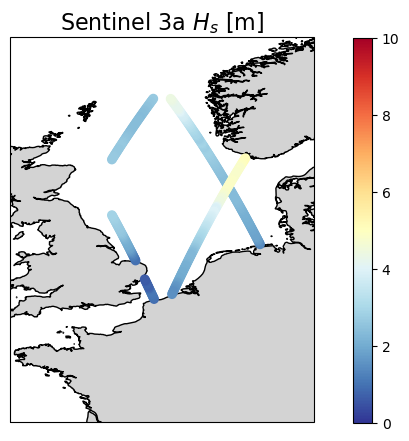

In [16]:
# Area of interest NWS
lon_min=-5. ; lon_max=10. ; lat_min=45. ; lat_max=64. # NWS
#lon_min=-180 ; lon_max=180.; lat_min=-90. ; lat_max=90. # Global

plt.figure()
# plot-frame definition (with high resolution lands)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
tracks = ax.scatter(subsetArea['longitude'], subsetArea['latitude'], c=subsetArea['VAVH'], vmin=-0., vmax=10., cmap='RdYlBu_r')

# add colorbar
cbar = plt.colorbar(tracks)
plt.title('Sentinel 3a $H_s$ [m]', size=16)
plt.show()

In [ ]:
# Create unique time values
time_values = subsetArea.time.values
unique_dates = np.unique(np.datetime_as_string(time_values, unit='D'))


# Plot satellite tracks for each day
for date in unique_dates:
    # Select data for the current date
    daily_data = subsetArea.sel(time=date)

    # Plotting
    plt.figure(figsize=(6, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)

    # Scatter plot for satellite tracks
    sc = ax.scatter(daily_data.longitude, daily_data.latitude, c=daily_data['VAVH'], cmap='viridis', marker='o', label='Satellite Data')
    
    # Title and colorbar
    plt.title(f'Satellite Tracks on {date}')
    cbar = plt.colorbar(sc, label='VAVH')
    
    # Save or show the plot
    plt.savefig(f'/p/i1000617-phd-waveda/dev/odawave/figures/04-explore-cmems-altimetry/sentinel3a_tracks_{date}.png')
    #plt.show()

In [ ]:
# Plot along track data for each day
for date in unique_dates:
    # Select daily data
    daily_track = subsetArea.sel(time=date)
    daily_track
    
    plt.figure(figsize=(6, 4))
    plt.plot(daily_track.latitude, daily_track.VAVH, label='$H_s$ [m]')
    plt.scatter(daily_track.latitude, daily_track.VAVH_UNFILTERED, label='$H_s$ [m] unfiltered', marker='o', color='r')
    plt.xlabel('latitude')
    plt.ylabel('$H_s$ [m]')
    plt.title(f'Sentinel 3a $H_s$ along track on {date}')


    